---
# Customer Lifetime Value (CLV) and Churn Prediction
---
## Authors
### Group 63
1. Debanjan Saha (saha.deb@northeastern.edu)
2. Ritika Rao (rao.rit@northeastern.edu)
- Affiliation: College of Engineering, Northeastern University, Boston
- Percentage of Contribution: 50-50

---
## Data Description
In this project, we use a retail store data to determine the customer lifetime value and predict the churn using the customer demographics data.
The dataset in available online in [Kaggle](https://www.kaggle.com/datasets/darpan25bajaj/retail-case-study-data)

The dataset comprises of three files:
- Customer: Customer information including demographics
- Transaction: Transaction of customers
- Product Hierarchy: Product information

A detailed description of the data dictionary is mentioned in our project report.

---
## Objective

We chose this dataset to handle the different prevalent scenarios that might considerably benefit holistic client profiling using Machine Learning in retail purchasing and marketing. In this project, we don't just develop one model with a specific goal in mind; instead, we look at numerous sorts of modeling and data mining techniques that can be performed using any transactional history dataset as well as customer demographic data. Customer demographics data is very sensitive for every organization because it contains a large amount of PII data. This is the only publically available dataset that provided us with all of the information we needed for our data mining problem. Our main goal was to make this project as much generalized as possible, and we aim to carry forward the learnings from this project into our future endeavors.


Using this data, we can perform various kinds of analysis such as:

- Customer Segmentation: Based on the customer demographics, purchase history and behavior, the customers can be segmented into different groups. This can be visualized using clustering techniques such as K-Means.

- Time Series Analysis: Time series analysis can be performed on the transactions dataset to identify trends and patterns in customer purchases over time.

- Market Basket Analysis: Market basket analysis is a technique that analyzes customer transactions to determine which items are frequently purchased together. This can be visualized using association rule mining techniques such as Apriori algorithm. A network graph can be used to show the relationship between items.

- RFM (Recency-Frequency-Monetary value) Clustering: RFM is one of the most commonly used Clustering technique which is used for customer segmentation, marketing, ads targetting. Using this data, we perform various analysis based on the results from our RFM clustering.

- Customer Churn Analysis: Customer churn analysis can be performed to predict which customers are likely to leave the company. This can be visualized using decision tree algorithms and plotted on a bar chart to show the probability of customer churn.

- Customer Lifetime Value (CLV) Analysis: CLV is a prediction of the net profit attributed to the entire future relationship with a customer. This can be calculated by analyzing the customer's purchase history, behavior and demographics.

---

All these experiments are conducted as part of the coursework project for IE 7275 - Data Mining under Prof. Sagar Kamarthi

## Import Libraries

In [1]:
# !pip install numpy --upgrade
# !pip install matplotlib --upgrade

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
from google.colab import files, drive
from datetime import datetime, timedelta, date
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
from scipy import stats
from scipy.stats import f_oneway, spearmanr
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, Lars, LassoLars
from sklearn.linear_model import RidgeCV, SGDRegressor, HuberRegressor, PoissonRegressor
from sklearn.feature_selection import RFE, f_regression, SelectKBest, RFECV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor

## Read Files

In [4]:
drive.mount('/content/drive', force_remount=True)
%cd '/content/drive/MyDrive/Northeastern/Projects/IE7275 Project/Data'

Mounted at /content/drive
/content/drive/MyDrive/Northeastern/Projects/IE7275 Project/Data


In [5]:
#Load Customer dataset
# file = files.upload()  #upload file into google colab session
cust = pd.read_csv("Customer.csv") 
cust.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [6]:
#Load product dataset
# file = files.upload()  #upload file into google colab session
prod_cat = pd.read_csv("prod_cat_info.csv") 
prod_cat.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [7]:
#Load Transaction dataset
# file = files.upload()  #upload file into google colab session
txn = pd.read_csv("Transactions.csv") 
txn.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


## Data Cleaning: 
- Format datetime fields into timestamp and extract datetime features
- One hot encode categorical column `Store_type` into $m-1$ columns
- Remove duplicate records, minus the date, basically double refund records need to be removed

In [8]:
# extract datetime field from the dataframe
txn['tran_date'] = pd.to_datetime(txn['tran_date'], infer_datetime_format=True)
txn.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop


In [9]:
# create new features from the 'tran_date' column
txn['year'] = txn['tran_date'].dt.year
txn['month'] = txn['tran_date'].dt.month
txn['day'] = txn['tran_date'].dt.day
txn['weekday'] = txn['tran_date'].dt.weekday

In [10]:
# one hot encoding Store_type column
store_type_encoded = pd.get_dummies(txn['Store_type'], drop_first=True)
store_type_encoded.columns = ['store_type_' + str(''.join(col.strip().split('-'))) for col in store_type_encoded.columns]
store_type_encoded = store_type_encoded[['store_type_eShop', 'store_type_MBR', 'store_type_TeleShop']]

In [11]:
# concatenate the one-hot encoded variables with the original dataframe
txn = txn.drop(columns=['Store_type'], axis=1)
txn = pd.concat([txn, store_type_encoded], axis=1)
txn.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,2014,2,28,4,1,0,0
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,2014,2,27,3,1,0,0
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,2014,2,24,0,0,0,1
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,2014,2,24,0,1,0,0
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,2014,2,23,6,0,0,1


In [12]:
txn.shape

(23053, 16)

In [13]:
txn[txn['total_amt'] < 0].head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,2014,2,28,4,1,0,0
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,2014,2,27,3,1,0,0
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,2014,2,24,0,0,0,1
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,2014,2,24,0,1,0,0
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,2014,2,23,6,0,0,1


There is a problem in the values of `Qty` and `Tax` in this dataset; where `total_amt` is negative, both colunms `Qty` and `Rate` as marked as negative, whereas `Tax` is marked as positive and `total_amt` is marked as negative again. This does not adhere the to the rule **total_amt = Qty * Rate + Tax**. So we will modify these columns to convert the `Qty` column to positive and `Tax` column to negative for the rows where the `total_amt` is negative. With this modification, the `Qty` column is converted to positive and the `Tax` column is converted to negative for the rows where the `total_amt` is negative, so that the rule **total_amt = Qty * Rate + Tax** is adhered to.

In [14]:
txn.loc[txn['total_amt'] < 0, 'Qty'] = -txn['Qty']
txn.loc[txn['total_amt'] < 0, 'Tax'] = -txn['Tax']

Next, there are many duplicate transactions or transactions which did not go through. We will deal with these transactions to make sure that these transactions don't introduce bias into our data. 

In [15]:
# find all the records which have duplicate values
mult_trxn = txn[txn[['cust_id', 'transaction_id', 'total_amt']] \
                .apply(lambda x: tuple(abs(x)), axis=1).duplicated(keep=False)] \
                .sort_values(['cust_id', 'transaction_id', 'tran_date', 'total_amt'])

mult_trxn

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
18130,25890929042,266783,2011-09-23,1,2,4,1321,554.820,5838.820,2011,9,23,4,1,0,0
18114,25890929042,266783,2011-09-24,1,2,4,-1321,-554.820,-5838.820,2011,9,24,5,1,0,0
12882,96176911576,266785,2012-02-06,10,6,5,-1236,-648.900,-6828.900,2012,2,6,0,0,0,0
13083,96176911576,266785,2012-05-23,10,6,5,1236,648.900,6828.900,2012,5,23,2,0,0,0
4908,42435707527,266794,2013-06-29,10,3,1,123,12.915,135.915,2013,6,29,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3550,96061314451,275257,2013-03-09,2,6,3,-347,-109.305,-1150.305,2013,3,9,5,1,0,0
4795,45067329959,275261,2013-05-07,3,5,3,-862,-271.530,-2857.530,2013,5,7,1,1,0,0
4958,45067329959,275261,2013-06-27,3,5,3,862,271.530,2857.530,2013,6,27,3,1,0,0
17859,62560589211,275261,2011-05-10,4,4,1,-367,-38.535,-405.535,2011,5,10,1,0,0,1


In [16]:
unq_dups = mult_trxn.groupby(['cust_id', 'transaction_id']).agg(pos_count=('total_amt', lambda x: (x > 0).sum()), neg_count=('total_amt', lambda x: (x < 0).sum()))
unq_dups_filt = unq_dups[unq_dups['pos_count'] != unq_dups['neg_count']]
unq_dups_filt

pos_count  neg_count
cust_id transaction_id                      
266845  28679132905             1          2
266852  4170892941              1          3
266881  4545655117              1          2
266883  86293071463             1          2
267042  17562417547             1          2
...                           ...        ...
274767  48660589294             1          2
        82258282007             1          2
274863  8746932604              1          2
275012  53673172604             1          2
275023  32505767697             1          2

[115 rows x 2 columns]

Here, we can see that out of the 23053 records, 4232 records are duplicates. Interesting to note, that out of the 4232 transactions, there were 115 transactions have one positive transaction while multiple negative transactions. One reason for this kind of a behavior in the data could probably be due the transactions not going through, so the person attempted the transaction multiple times (maybe through credit card).

Hence, we cannot really consider these incomplete transactions as real transactions. Thus, we will have to reject the multiple transactions which did not go through.

In [17]:
# one such example where we have multiple transactions which did not go through
txn[txn['transaction_id'] == 4170892941]

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
16207,4170892941,266852,2011-12-24,8,3,1,-412,-43.26,-455.26,2011,12,24,5,0,1,0
16267,4170892941,266852,2011-12-21,8,3,1,-412,-43.26,-455.26,2011,12,21,2,0,1,0
16269,4170892941,266852,2011-12-21,8,3,1,-412,-43.26,-455.26,2011,12,21,2,0,1,0
16288,4170892941,266852,2011-12-20,8,3,1,412,43.26,455.26,2011,12,20,1,0,1,0


Now, we will clean the data and remove the unnecessary multiple transactions which did not go through but keeping the first transaction

In [18]:
# Find the rows where neg_count > 1
mult_negs = unq_dups.loc[unq_dups['neg_count'] > 1, :].index

# Filter the rows to keep only the first negative total_amt for each affected transaction
rows_to_drop = pd.concat([
    pd.Series(df_neg.iloc[1:].index) for (cust_id, transaction_id), df_neg in 
    txn.loc[txn['total_amt'] < 0].groupby(['cust_id', 'transaction_id']) if len(df_neg) > 1
]).reset_index(drop=True)

print(f'Dropping {rows_to_drop.shape[0]} duplicate records')    
# Drop the selected rows from the main dataframe
txn = txn.drop(index=rows_to_drop)
print('Number of Transactions After Drop = ', txn.shape[0])


Dropping 118 duplicate records
Number of Transactions After Drop =  22935


So, we have cleaned up most of the records. Now we will check for correlation among the data.

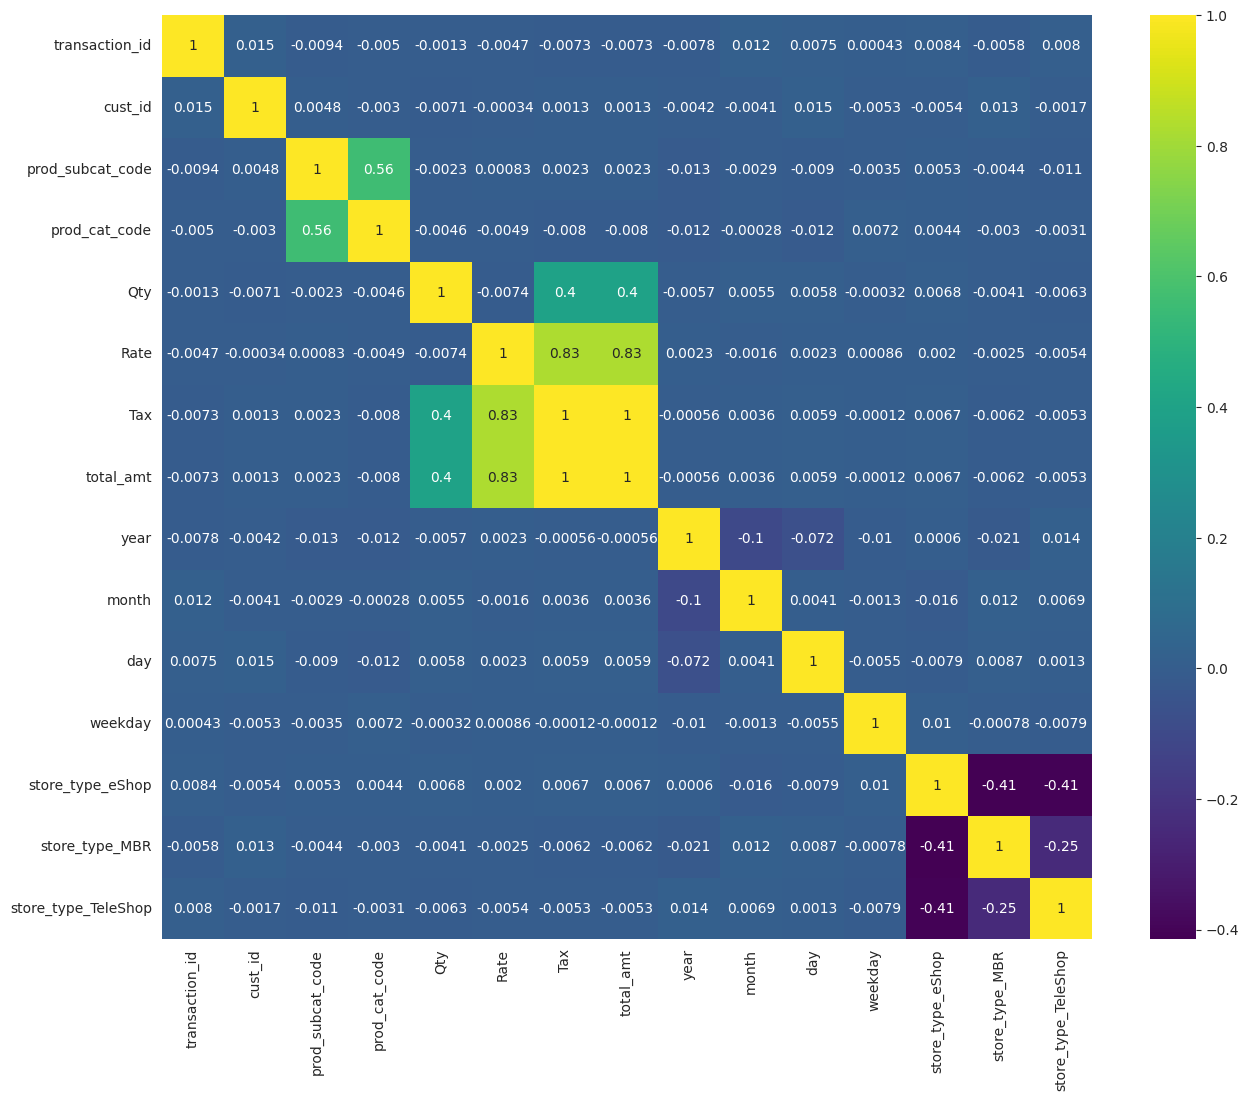

In [19]:
# plot correlation heatmap
plt.figure(figsize=(15,12))
sns.heatmap(txn.corr(), annot=True, cmap='viridis')
plt.show()

From the heatmap above we can see that Tax has 100% direct correlation with total_amt. Also, we can see that Rate has a very high correlation (0.83) with the total_amt. There is no point in keeping these columns. So we will drop these two columns.

In [20]:
txn = txn.drop(['Rate', 'Tax'], axis=1)

## Feature Selection

We will try to use the total_amt as the target and try to select subset of features using Recursive Feature Selection Method to find the feature importance

In [21]:
# Split the data into features and target
X = txn.drop(['total_amt', 'tran_date'], axis=1)
y = txn['total_amt']

In [22]:
X.head()

,transaction_id,cust_id,prod_subcat_code,prod_cat_code,Qty,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
0,80712190438,270351,1,1,5,2014,2,28,4,1,0,0
1,29258453508,270384,5,3,5,2014,2,27,3,1,0,0
2,51750724947,273420,6,5,2,2014,2,24,0,0,0,1
3,93274880719,271509,11,6,3,2014,2,24,0,1,0,0
5,97439039119,272357,8,3,2,2014,2,23,6,0,0,1


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Recursive Feature Elimination with Cross Validation

In [24]:
def recursive_feature_elimination(estimator):
    # Define the recursive feature elimination object and fit on training data
    selector = RFECV(estimator, step=1, cv=5)
    selector.fit(X_train, y_train)

    # Print the ranking of each feature
    print(f"\nModel: {str(estimator)[:-2]} \nRankings:")
    ranked_features = sorted(zip(X_train.columns, selector.ranking_), key=lambda x: x[1])
    for feature in ranked_features:
        print(f"Rank: {feature[1]} \t Feature: {feature[0]}")

In [25]:
# Define the estimator to use
rfe_models = [LinearRegression(),
              RandomForestRegressor(),
              XGBRegressor()
              ]

for estimator in rfe_models:
    recursive_feature_elimination(estimator)


Model: LinearRegression 
Rankings:
Rank: 1 	 Feature: Qty
Rank: 2 	 Feature: store_type_TeleShop
Rank: 3 	 Feature: store_type_MBR
Rank: 4 	 Feature: prod_cat_code
Rank: 5 	 Feature: prod_subcat_code
Rank: 6 	 Feature: store_type_eShop
Rank: 7 	 Feature: weekday
Rank: 8 	 Feature: day
Rank: 9 	 Feature: month
Rank: 10 	 Feature: year
Rank: 11 	 Feature: cust_id
Rank: 12 	 Feature: transaction_id

Model: RandomForestRegressor 
Rankings:
Rank: 1 	 Feature: transaction_id
Rank: 1 	 Feature: cust_id
Rank: 1 	 Feature: prod_subcat_code
Rank: 1 	 Feature: prod_cat_code
Rank: 1 	 Feature: Qty
Rank: 1 	 Feature: year
Rank: 1 	 Feature: month
Rank: 1 	 Feature: day
Rank: 1 	 Feature: weekday
Rank: 2 	 Feature: store_type_eShop
Rank: 3 	 Feature: store_type_MBR
Rank: 4 	 Feature: store_type_TeleShop

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
      

In [26]:
# Now lets drop transaction_id from X_train and run feature selection again
X_train.drop('transaction_id', axis=1, inplace=True)

for estimator in rfe_models:
    recursive_feature_elimination(estimator)


Model: LinearRegression 
Rankings:
Rank: 1 	 Feature: Qty
Rank: 2 	 Feature: store_type_TeleShop
Rank: 3 	 Feature: store_type_MBR
Rank: 4 	 Feature: prod_cat_code
Rank: 5 	 Feature: prod_subcat_code
Rank: 6 	 Feature: store_type_eShop
Rank: 7 	 Feature: weekday
Rank: 8 	 Feature: day
Rank: 9 	 Feature: month
Rank: 10 	 Feature: year
Rank: 11 	 Feature: cust_id

Model: RandomForestRegressor 
Rankings:
Rank: 1 	 Feature: cust_id
Rank: 1 	 Feature: prod_subcat_code
Rank: 1 	 Feature: prod_cat_code
Rank: 1 	 Feature: Qty
Rank: 1 	 Feature: year
Rank: 1 	 Feature: month
Rank: 1 	 Feature: day
Rank: 1 	 Feature: weekday
Rank: 1 	 Feature: store_type_eShop
Rank: 1 	 Feature: store_type_MBR
Rank: 2 	 Feature: store_type_TeleShop

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None

In [27]:
# Now lets drop cust_id from X_train and run feature selection again
X_train.drop('cust_id', axis=1, inplace=True)

for estimator in rfe_models:
    recursive_feature_elimination(estimator)


Model: LinearRegression 
Rankings:
Rank: 1 	 Feature: Qty
Rank: 2 	 Feature: store_type_TeleShop
Rank: 3 	 Feature: store_type_MBR
Rank: 4 	 Feature: prod_cat_code
Rank: 5 	 Feature: prod_subcat_code
Rank: 6 	 Feature: store_type_eShop
Rank: 7 	 Feature: weekday
Rank: 8 	 Feature: day
Rank: 9 	 Feature: month
Rank: 10 	 Feature: year

Model: RandomForestRegressor 
Rankings:
Rank: 1 	 Feature: prod_subcat_code
Rank: 1 	 Feature: prod_cat_code
Rank: 1 	 Feature: Qty
Rank: 1 	 Feature: year
Rank: 1 	 Feature: month
Rank: 1 	 Feature: day
Rank: 1 	 Feature: weekday
Rank: 1 	 Feature: store_type_eShop
Rank: 1 	 Feature: store_type_MBR
Rank: 2 	 Feature: store_type_TeleShop

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=Non

Using the three different methods, we are getting different set of responses.
We are rather interested in finding how much does the product category, sub-category and store type contribute to the target.

While using Random Forest Regressor is an ideal choice for this problem setting (as $n >> d$), yet we see that Linear Regressor is able to classify importance to store type and product category while Random Forest classifies these predictors as the least most important features, probably because some of these features have been one-hot encoded making them sparse.

Thus, we do not get any concrete set of features to be eliminated from these methods. So we will proceed with the full set of features.

# Recency-Frequency-Monetary (RFM) value based Clustering 

This allows us to cluster the transaction data into clusters of:
- Low Value: Customers less active than others, not very frequent buyer, generates low revenue - zero - maybe negative
- Mid Value: Fairly frequent, generates more revenue
- High Value: The group we don't want to lose, High Revenue, frequency and low inactivity
 

## Recency
Find most recent purchase date of each customer. Find number of inactive days and apply clustering algorithm to assign them a recency score.

In [28]:
recency_customer = pd.DataFrame(txn['cust_id'].unique())
recency_customer.columns = ['Customer ID']
recency_customer.head()

,Customer ID
0,270351
1,270384
2,273420
3,271509
4,272357


Check if there are any customers with just negative transactions.

In [29]:
#Get max revenue for each customer
max_revenue_df = txn.groupby('cust_id').total_amt.max().reset_index()
max_revenue_df.columns = ['cust_id' , 'total_amt']
negative_revenue_df = max_revenue_df[max_revenue_df['total_amt'] < 0]
print(negative_revenue_df['cust_id'].nunique())

0


Thus, are 0 customers with just negative transactions. We can go ahead and remove the negative transactions to go ahead and find the most recent purchase for every single customer ID.

In [30]:
# Data pre-processing: Remove negative transactions
df_positive_revenue = txn[txn['total_amt'] >= 0]
df_positive_revenue.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,total_amt,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
10,29258453508,270384,2014-02-20,5,3,5,8270.925,2014,2,20,3,1,0,0
11,25455265351,267750,2014-02-20,12,6,3,4508.400,2014,2,20,3,1,0,0
12,1571002198,275023,2014-02-20,6,5,4,2594.540,2014,2,20,3,1,0,0
14,36554696014,269345,2014-02-20,3,5,3,4153.695,2014,2,20,3,1,0,0
15,56814940239,268799,2014-02-20,7,5,5,2033.200,2014,2,20,3,1,0,0


Check if there are any transactions with 0 total_amount

In [31]:
df_temp = df_positive_revenue[df_positive_revenue['total_amt'] == 0]
df_temp['cust_id'].nunique()

0

Since, there are no transactions with 0 revenue we proceed further

We find the most recent transaction date for every customer

In [32]:
#Get the Date of last purchase for each Customer
last_purchase = df_positive_revenue.groupby('cust_id').tran_date.max().reset_index()
last_purchase.columns = ['Customer ID', 'Recent Purchase Date']
last_purchase.head()

,Customer ID,Recent Purchase Date
0,266783,2013-09-02
1,266784,2012-09-09
2,266785,2013-02-13
3,266788,2013-12-02
4,266794,2014-12-02


Using the best/most recent customer as benchmark, get the recency for every other customer, by finding difference between the 2 dates in days

In [33]:
last_purchase['Recency'] = (last_purchase['Recent Purchase Date'].max() - last_purchase['Recent Purchase Date']).dt.days
last_purchase.head()

,Customer ID,Recent Purchase Date,Recency
0,266783,2013-09-02,456
1,266784,2012-09-09,814
2,266785,2013-02-13,657
3,266788,2013-12-02,365
4,266794,2014-12-02,0


In [34]:
#For General analysis find the top 10 and bottom 10 customer ids
#TOP 10 CUSTOMERS
print((last_purchase.sort_values(['Recency'], ascending=True)).head(10))
#BOTTOM 10 CUSTOMERS
print((last_purchase.sort_values(['Recency'], ascending=False)).head(10))

      Customer ID Recent Purchase Date  Recency
5110       274678           2014-12-02        0
5253       274897           2014-12-02        0
3347       271944           2014-12-02        0
1941       269772           2014-12-02        0
4541       273799           2014-12-02        0
2848       271180           2014-12-02        0
853        268100           2014-12-02        0
4387       273552           2014-12-02        0
4456       273667           2014-12-02        0
443        267466           2014-12-02        0
      Customer ID Recent Purchase Date  Recency
842        268084           2011-01-04     1428
1056       268440           2011-01-06     1426
1702       269402           2011-01-07     1425
3623       272380           2011-01-07     1425
4491       273723           2011-01-26     1406
1803       269556           2011-01-29     1403
5277       274935           2011-01-29     1403
722        267902           2011-01-30     1402
5274       274931           2011-01-31  

In [35]:
#Merge the last purchase dataset with the unique customers dataset
recency_customer = pd.merge(recency_customer, last_purchase, on = 'Customer ID')

In [36]:
recency_customer.head()

,Customer ID,Recent Purchase Date,Recency
0,270351,2014-02-20,285
1,270384,2014-02-20,285
2,273420,2014-02-16,289
3,271509,2014-02-16,289
4,272357,2013-09-16,442


Check if the number of customers is correct

In [37]:
assert recency_customer.shape[0] == txn['cust_id'].nunique()

Visualize customers who have churned out

In [38]:
# Box Plot customers on their latest purchase
fig = go.Figure()

fig.add_trace(go.Box(x=recency_customer['Recency'], 
                     #name='Churned Customers', 
                     boxpoints='all', 
                     jitter=0.3, 
                     pointpos=-1.8))

fig.update_layout(title='Churned Customers Box Plot',
                  xaxis_title='Recency',
                  yaxis_title='Number of Customers')

fig.show()

In [39]:
# plot the distribution of recency
fig = px.histogram(recency_customer, x='Recency', nbins=20, 
                   labels={'Recency': 'Recency', 'count': 'Count of Customers'}, 
                   title='Recency Distribution')
fig.show()

In [40]:
#create a copy of the recency dataframe
recency_customer2 = recency_customer.copy()

### Recency Cluster - DBSCAN

In [41]:
# Plot the elbow curve to find optimal value of minimum points required

recency = recency_customer2[['Recency']].values
eps_values = np.arange(1, 50, 1)
min_samples_values = np.arange(1, 30, 1)
sse = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(recency)
        sse.append([eps, min_samples, sum(dbscan.labels_ == -1)])
sse = np.array(sse)

fig = px.line(sse, x=sse[:, 0], y=sse[:, 2], hover_data=[sse[:, 1]])
fig.update_layout(title="Elbow Curve for DBSCAN", xaxis_title="Max Distance", yaxis_title="Number of Data Points")
fig.show()


In [42]:
#Apply DBSCAN to cluster the customers based on recency
dbscan = DBSCAN(eps=29, min_samples=10)
recency_customer2['RecencyCluster'] = dbscan.fit_predict(recency_customer2[['Recency']])

In [43]:
recency_customer2['RecencyCluster'].value_counts()

0    5185
1      82
3      73
5      70
2      56
4      40
Name: RecencyCluster, dtype: int64

In [44]:
#Analyze the clusters
recency_customer2.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,5185.0,573.099132,244.695529,275.0,386.00,501.0,698.0,1428.0
1,82.0,14.097561,14.985268,0.0,1.00,1.0,30.0,31.0
2,56.0,227.392857,14.957733,214.0,214.75,215.0,244.0,245.0
3,73.0,165.767123,14.782235,153.0,153.00,154.0,183.0,184.0
4,40.0,122.575000,0.500641,122.0,122.00,123.0,123.0,123.0
5,70.0,75.671429,15.050371,61.0,62.00,62.0,91.0,92.0


### Recency Cluster - KMeans++

Assigning a score for recency:
We use a KMeans algorithm, but we need to define the number of clusters we want.
To find number of customer, we apply the elbow method.

In [45]:
# Clustering the customers based on Recency
sse = {}
recency = recency_customer[['Recency']]
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, max_iter=1000).fit(recency)
    # sse corresponding to clusters
    sse[i] = kmeans.inertia_

# Plotting the Elbow curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(sse.keys()), y=list(sse.values()), mode='lines+markers'))
fig.update_layout(title='Elbow Curve for Optimal K',
                  xaxis_title='Number of Clusters',
                  yaxis_title='SSE (Sum of Squared Errors)')
fig.show()

Here, 3 is the optimal number of clusters, we can choose more or less but here we try 3 & 4.

In [46]:
kmeans = KMeans(n_clusters=3, 
                init='k-means++', 
                n_init=10, max_iter=1000)
recency_customer['RecencyCluster'] = kmeans.fit_predict(recency_customer[['Recency']])
recency_customer.head()

,Customer ID,Recent Purchase Date,Recency,RecencyCluster
0,270351,2014-02-20,285,0
1,270384,2014-02-20,285,0
2,273420,2014-02-16,289,0
3,271509,2014-02-16,289,0
4,272357,2013-09-16,442,0


In [47]:
recency_customer.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2883.0,356.079778,106.001103,0.0,316.0,373.0,430.0,498.0
1,719.0,1057.308762,153.907867,849.0,924.0,1030.0,1171.0,1428.0
2,1904.0,641.243172,96.541514,499.0,557.0,628.0,719.0,848.0


Recorder the clusters, based on their means

In [48]:
recency_customer['NewRecencyCluster'] = 0

In [49]:
recency_customer.loc[recency_customer['RecencyCluster'] == 0,'NewRecencyCluster'] = 1
recency_customer.loc[recency_customer['RecencyCluster'] == 1,'NewRecencyCluster'] = 0
recency_customer.loc[recency_customer['RecencyCluster'] == 2,'NewRecencyCluster'] = 2
recency_customer.head()

,Customer ID,Recent Purchase Date,Recency,RecencyCluster,NewRecencyCluster
0,270351,2014-02-20,285,0,1
1,270384,2014-02-20,285,0,1
2,273420,2014-02-16,289,0,1
3,271509,2014-02-16,289,0,1
4,272357,2013-09-16,442,0,1


In [50]:
recency_customer['RecencyCluster'] = recency_customer['NewRecencyCluster']
recency_customer = recency_customer[['Customer ID', 'Recency', 'RecencyCluster']]
recency_customer.head()

,Customer ID,Recency,RecencyCluster
0,270351,285,1
1,270384,285,1
2,273420,289,1
3,271509,289,1
4,272357,442,1


Trying 4 clusters

In [51]:
recency_customer_new = recency_customer.copy()
kmeans = KMeans(n_clusters=4, 
                init='k-means++', 
                n_init=10, max_iter=1000)
recency_customer_new['RecencyCluster'] = kmeans.fit_predict(recency_customer_new[['Recency']])
recency_customer_new.head()

,Customer ID,Recency,RecencyCluster
0,270351,285,2
1,270384,285,2
2,273420,289,2
3,271509,289,2
4,272357,442,1


In [52]:
recency_customer_new.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,523.0,1121.634799,130.968447,936.0,1007.5,1104.0,1217.5,1428.0
1,2016.0,492.868552,63.545369,398.0,437.0,485.0,544.0,619.0
2,1758.0,299.935154,99.152879,0.0,289.0,335.0,364.0,397.0
3,1209.0,744.570720,85.796831,620.0,669.0,734.0,809.0,933.0


Trying 5 clusters

In [53]:
recency_customer_new2 = recency_customer.copy()
kmeans = KMeans(n_clusters=5, 
                init='k-means++', 
                n_init=10, max_iter=1000)
recency_customer_new2['RecencyCluster'] = kmeans.fit_predict(recency_customer_new2[['Recency']])
recency_customer_new2.head()

,Customer ID,Recency,RecencyCluster
0,270351,285,0
1,270384,285,0
2,273420,289,0
3,271509,289,0
4,272357,442,0


In [54]:
recency_customer_new2.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2329.0,374.393302,54.023309,244.0,335.00,374.0,420.00,469.0
1,454.0,1147.418502,121.244781,972.0,1045.25,1132.5,1239.25,1428.0
2,923.0,797.211268,79.916454,681.0,730.50,782.0,860.00,971.0
3,297.0,102.097643,70.012310,0.0,31.00,92.0,154.00,215.0
4,1503.0,564.651364,60.364888,470.0,511.00,561.0,616.00,680.0


## Frequency
Determining the number of orders per customer

In [55]:
df_freq = txn.copy()

We calculate the frequency by counting number of transcations with positive revenue and subtracting the number of transactions with negative revenue from it.

In [56]:
#Filetering positive revenue transactions
positive_revenue_txn = df_freq[df_freq['total_amt'] >= 0]
negative_revenue_txn = df_freq[df_freq['total_amt'] < 0]

In [57]:
positive_revenue_txn.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,total_amt,year,month,day,weekday,store_type_eShop,store_type_MBR,store_type_TeleShop
10,29258453508,270384,2014-02-20,5,3,5,8270.925,2014,2,20,3,1,0,0
11,25455265351,267750,2014-02-20,12,6,3,4508.400,2014,2,20,3,1,0,0
12,1571002198,275023,2014-02-20,6,5,4,2594.540,2014,2,20,3,1,0,0
14,36554696014,269345,2014-02-20,3,5,3,4153.695,2014,2,20,3,1,0,0
15,56814940239,268799,2014-02-20,7,5,5,2033.200,2014,2,20,3,1,0,0


In [58]:
#Get total positive purchases
positive_purchase = positive_revenue_txn.groupby('cust_id').transaction_id.count().reset_index()
positive_purchase.columns = ['Customer ID', 'Total Positive Transaction']
positive_purchase.head()

,Customer ID,Total Positive Transaction
0,266783,4
1,266784,3
2,266785,7
3,266788,4
4,266794,11


In [59]:
positive_purchase.shape

(5506, 2)

In [60]:
#Get total negative purchases
negative_purchase = negative_revenue_txn.groupby('cust_id').transaction_id.count().reset_index()
negative_purchase.columns = ['Customer ID', 'Total Negative Transaction']
negative_purchase.head()

,Customer ID,Total Negative Transaction
0,266783,1
1,266785,1
2,266794,1
3,266799,1
4,266816,1


In [61]:
negative_purchase.shape

(1728, 2)

In [62]:
#Get total transactions
frequency_customer = pd.merge(positive_purchase, negative_purchase, how='left', on = 'Customer ID')
frequency_customer.head()

,Customer ID,Total Positive Transaction,Total Negative Transaction
0,266783,4,1.0
1,266784,3,NaN
2,266785,7,1.0
3,266788,4,NaN
4,266794,11,1.0


In [63]:
frequency_customer.shape

(5506, 3)

In [64]:
#Relace NaN values with 0
frequency_customer['Total Negative Transaction'] = frequency_customer['Total Negative Transaction'].fillna(0)
frequency_customer.head()

,Customer ID,Total Positive Transaction,Total Negative Transaction
0,266783,4,1.0
1,266784,3,0.0
2,266785,7,1.0
3,266788,4,0.0
4,266794,11,1.0


In [65]:
frequency_customer['Total Transaction'] = frequency_customer['Total Positive Transaction'] - frequency_customer['Total Negative Transaction']
frequency_customer.head()

,Customer ID,Total Positive Transaction,Total Negative Transaction,Total Transaction
0,266783,4,1.0,3.0
1,266784,3,0.0,3.0
2,266785,7,1.0,6.0
3,266788,4,0.0,4.0
4,266794,11,1.0,10.0


In [66]:
frequency_customer.sort_values(['Total Transaction'], ascending=False).head(10)

,Customer ID,Total Positive Transaction,Total Negative Transaction,Total Transaction
2426,270535,11,0.0,11.0
2606,270803,11,0.0,11.0
3867,272741,11,0.0,11.0
366,267346,10,0.0,10.0
4032,273014,11,1.0,10.0
3604,272354,10,0.0,10.0
4,266794,11,1.0,10.0
3099,271565,10,0.0,10.0
4815,274227,11,1.0,10.0
3717,272518,10,0.0,10.0


In [67]:
frequency_customer = frequency_customer[['Customer ID','Total Transaction']]
frequency_customer.head()

,Customer ID,Total Transaction
0,266783,3.0
1,266784,3.0
2,266785,6.0
3,266788,4.0
4,266794,10.0


In [68]:
frequency_customer[frequency_customer['Total Transaction'] < 0]

,Customer ID,Total Transaction


In [69]:
frequency_customer2 = frequency_customer.copy()

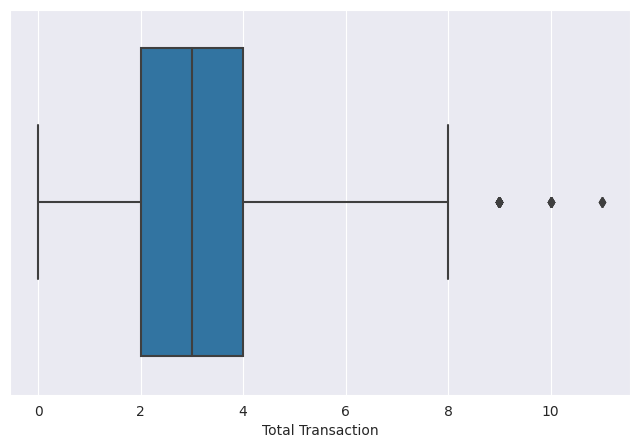

In [70]:
plt.figure(figsize=(8,5))
sns.boxplot(x=frequency_customer['Total Transaction'], whis=2)
plt.show()

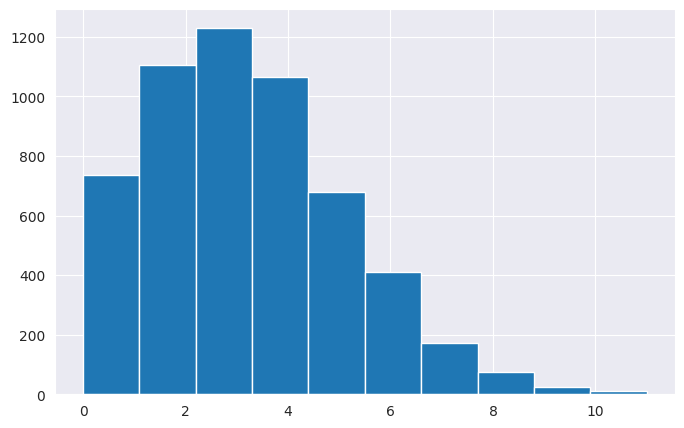

In [71]:
plt.figure(figsize=(8,5))
plt.hist(frequency_customer['Total Transaction'])
plt.show()

### Frequency Cluster - DBSCAN

In [72]:
#Plot the elbow curve to find optimal value of minimum points required
frequency = frequency_customer2[['Total Transaction']].values
eps_values = np.arange(1, 20, 1)
min_samples_values = np.arange(1, 10, 1)
sse = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(recency)
        sse.append([eps, min_samples, sum(dbscan.labels_ == -1)])
sse = np.array(sse)

fig = px.line(sse, x=sse[:, 0], y=sse[:, 2], hover_data=[sse[:, 1]])
fig.update_layout(title="Elbow Curve for DBSCAN", xaxis_title="Max Distance", yaxis_title="Number of Data Points")
fig.show()

In [73]:
#Apply DBSCAN to cluster the customers based on recency
dbscan = DBSCAN(eps=9, min_samples=2)
frequency_customer2['FrequencyCluster'] = dbscan.fit_predict(frequency_customer2[['Total Transaction']])

In [74]:
frequency_customer2['FrequencyCluster'].value_counts()

0    5506
Name: FrequencyCluster, dtype: int64

In [75]:
#Analyze the cluster
frequency_customer2.groupby('FrequencyCluster')['Total Transaction'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,5506.0,3.417544,1.7557,0.0,2.0,3.0,4.0,11.0


### Frequency Cluster - KMeans++

In [76]:
# Clustering the customers based on Frequency
sse = {}
frequency = frequency_customer[['Total Transaction']]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, max_iter=1000).fit(frequency)
    # sse corresponding to clusters
    sse[i] = kmeans.inertia_

# Plotting the Elbow curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(sse.keys()), y=list(sse.values()), mode='lines+markers'))
fig.update_layout(title='Elbow Curve for Optimal K',
                  xaxis_title='Number of Clusters',
                  yaxis_title='SSE (Sum of Squared Errors)')
fig.show()

For clusters = 3

In [77]:
kmeans = KMeans(n_clusters=3, 
                init='k-means++', 
                n_init=10, max_iter=1000)
frequency_customer['FrequencyCluster'] = kmeans.fit_predict(frequency_customer[['Total Transaction']])
frequency_customer.head()

,Customer ID,Total Transaction,FrequencyCluster
0,266783,3.0,1
1,266784,3.0,1
2,266785,6.0,2
3,266788,4.0,1
4,266794,10.0,2


In [78]:
frequency_customer.groupby('FrequencyCluster')['Total Transaction'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1841.0,1.565997,0.559615,0.0,1.0,2.0,2.0,2.0
1,2295.0,3.463617,0.498783,3.0,3.0,3.0,4.0,4.0
2,1370.0,5.828467,1.061543,5.0,5.0,6.0,6.0,11.0


In [79]:
frequency_customer = frequency_customer[['Customer ID', 'Total Transaction', 'FrequencyCluster']]
frequency_customer.columns = ['Customer ID', 'Frequency', 'FrequencyCluster']
frequency_customer.head()

,Customer ID,Frequency,FrequencyCluster
0,266783,3.0,1
1,266784,3.0,1
2,266785,6.0,2
3,266788,4.0,1
4,266794,10.0,2


For cluster = 4

In [80]:
frequency_customer_new = frequency_customer.copy()
kmeans = KMeans(n_clusters=4, 
                init='k-means++', 
                n_init=10, max_iter=1000)
frequency_customer_new['FrequencyCluster'] = kmeans.fit_predict(frequency_customer_new[['Frequency']])

In [81]:
frequency_customer_new.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1841.0,1.565997,0.559615,0.0,1.0,2.0,2.0,2.0
1,1088.0,5.375919,0.484582,5.0,5.0,5.0,6.0,6.0
2,2295.0,3.463617,0.498783,3.0,3.0,3.0,4.0,4.0
3,282.0,7.574468,0.853997,7.0,7.0,7.0,8.0,11.0


In [82]:
frequency_customer_new.head()

,Customer ID,Frequency,FrequencyCluster
0,266783,3.0,2
1,266784,3.0,2
2,266785,6.0,1
3,266788,4.0,2
4,266794,10.0,3


## Revenue

In [83]:
df_rev = txn.copy()

In [84]:
#Get total revenue purchases
revenue_customer = df_rev.groupby('cust_id').total_amt.sum().reset_index()
revenue_customer.columns = ['Customer ID', 'Revenue']
revenue_customer.head()

,Customer ID,Revenue
0,266783,3113.890
1,266784,5694.065
2,266785,21613.800
3,266788,6092.970
4,266794,27981.915


In [85]:
revenue_customer2 = revenue_customer.copy()

### Revenue Cluster - DBSCAN

In [86]:
#Plot the elbow curve to find optimal value of minimum points required
frequency = revenue_customer2[['Revenue']].values
eps_values = np.arange(1, 20, 1)
min_samples_values = np.arange(1, 10, 1)
sse = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(recency)
        sse.append([eps, min_samples, sum(dbscan.labels_ == -1)])
sse = np.array(sse)

fig = px.line(sse, x=sse[:, 0], y=sse[:, 2], hover_data=[sse[:, 1]])
fig.update_layout(title="Elbow Curve for DBSCAN", xaxis_title="Max Distance", yaxis_title="Number of Data Points")
fig.show()

In [87]:
#Apply DBSCAN to cluster the customers based on recency
dbscan = DBSCAN(eps=30, min_samples=35)
revenue_customer2['RevenueCluster'] = dbscan.fit_predict(revenue_customer2[['Revenue']])

In [88]:
#Analyze the cluster
revenue_customer2.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
-1,5242.0,9062.006136,5886.235839,97.240,4376.62875,8094.125,12756.39625,41510.430
0,59.0,4817.387966,28.979446,4768.075,4791.28000,4816.695,4841.55750,4867.525
1,62.0,0.000000,0.000000,0.000,0.00000,0.000,0.00000,0.000
2,36.0,7228.296111,18.966025,7194.655,7212.33500,7228.910,7245.48500,7257.640
3,35.0,8215.517143,19.251682,8186.945,8199.10000,8216.780,8231.69750,8245.510
4,37.0,7400.065541,18.388622,7369.245,7384.71500,7401.290,7414.55000,7434.440
5,35.0,8352.379286,18.462141,8326.175,8337.77750,8349.380,8368.71750,8384.740


### Revenue Cluster - KMeans++

In [89]:
# Clustering the customers based on Frequency
sse = {}
revenue = revenue_customer[['Revenue']]
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, max_iter=1000).fit(revenue)
    # sse corresponding to clusters
    sse[i] = kmeans.inertia_

# Plotting the Elbow curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(sse.keys()), y=list(sse.values()), mode='lines+markers'))
fig.update_layout(title='Elbow Curve for Optimal K',
                  xaxis_title='Number of Clusters',
                  yaxis_title='SSE (Sum of Squared Errors)')
fig.show()

For clusters = 3

In [90]:
kmeans = KMeans(n_clusters=3, 
                init='k-means++', 
                n_init=10, max_iter=1000)
revenue_customer['RevenueCluster'] = kmeans.fit_predict(revenue_customer[['Revenue']])

In [91]:
revenue_customer.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,980.0,18449.795995,3733.429640,14307.54,15692.10500,17370.0475,20083.09875,41510.430
1,2148.0,10180.794551,2084.105562,6957.08,8338.33000,10003.0125,11912.45250,14298.700
2,2378.0,3764.513349,1972.329380,0.00,2135.68875,3907.8325,5466.15875,6951.555


For clusters = 4

In [92]:
revenue_customer_new = revenue_customer.copy()
kmeans = KMeans(n_clusters=4, 
                init='k-means++', 
                n_init=10, max_iter=1000)
revenue_customer_new['RevenueCluster'] = kmeans.fit_predict(revenue_customer_new[['Revenue']])

In [93]:
revenue_customer_new.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,479.0,21248.340282,3523.250471,17495.465,18580.0225,20137.520,22845.875,41510.430
1,1937.0,8014.542752,1530.959212,5471.960,6687.4600,7923.955,9300.785,10864.360
2,1305.0,13747.771556,1860.021093,10867.675,12146.1600,13562.770,15307.565,17481.100
3,1785.0,2945.766571,1559.682218,0.000,1647.5550,3078.530,4287.400,5468.645


## Overall Score based on RFM clustering

In [94]:
customer_profile = pd.merge(recency_customer, revenue_customer, on = 'Customer ID')

In [95]:
customer_profile = pd.merge(customer_profile, frequency_customer, on = 'Customer ID')

In [96]:
customer_profile.head()

,Customer ID,Recency,RecencyCluster,Revenue,RevenueCluster,Frequency,FrequencyCluster
0,270351,285,1,5769.205,2,3.0,1
1,270384,285,1,12240.085,1,8.0,2
2,273420,289,1,583.440,2,1.0,0
3,271509,289,1,15508.675,0,4.0,1
4,272357,442,1,9952.735,1,5.0,2


In [97]:
customer_profile['Overall Score'] = customer_profile['RecencyCluster'] + customer_profile['RevenueCluster'] + customer_profile['FrequencyCluster']

In [98]:
customer_profile.head()

,Customer ID,Recency,RecencyCluster,Revenue,RevenueCluster,Frequency,FrequencyCluster,Overall Score
0,270351,285,1,5769.205,2,3.0,1,4
1,270384,285,1,12240.085,1,8.0,2,4
2,273420,289,1,583.440,2,1.0,0,3
3,271509,289,1,15508.675,0,4.0,1,2
4,272357,442,1,9952.735,1,5.0,2,4


In [99]:
customer_profile.groupby('Overall Score')[['Recency', 'Revenue', 'Frequency']].mean()

,Recency,Revenue,Frequency
Overall Score,,,
1,1002.870130,10415.026818,2.155844
2,855.218712,7028.072558,2.127582
3,409.857704,10881.059163,3.703631
4,522.785264,8095.705637,3.541444
5,618.944785,6833.993395,4.010225
6,636.500000,6014.791250,5.312500


In [100]:
customer_profile['Segment'] = 'Low Value'
customer_profile.loc[customer_profile['Overall Score'] > 1 , ['Segment']] = 'Mid Value'
customer_profile.loc[customer_profile['Overall Score'] > 4 , ['Segment']] = 'High Value'

In [101]:
customer_profile.head() 

,Customer ID,Recency,RecencyCluster,Revenue,RevenueCluster,Frequency,FrequencyCluster,Overall Score,Segment
0,270351,285,1,5769.205,2,3.0,1,4,Mid Value
1,270384,285,1,12240.085,1,8.0,2,4,Mid Value
2,273420,289,1,583.440,2,1.0,0,3,Mid Value
3,271509,289,1,15508.675,0,4.0,1,2,Mid Value
4,272357,442,1,9952.735,1,5.0,2,4,Mid Value


## Heirarchical Clustering

In [102]:
def dendoOptimizer(data):
    plt.figure(figsize=(10,6))
    sch.dendrogram(sch.linkage(data, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    plt.show()

In [103]:
def heirarchicalTrainer(noOfClusters, data):
    hc = AgglomerativeClustering(n_clusters=noOfClusters, affinity='euclidean', linkage='ward')
    hc_labels = hc.fit_predict(data)
    return (hc, hc_labels)

In [104]:
customer_profile_1 = customer_profile.copy()

In [105]:
clustering_data = customer_profile_1[['Recency', 'Frequency', 'Revenue']]

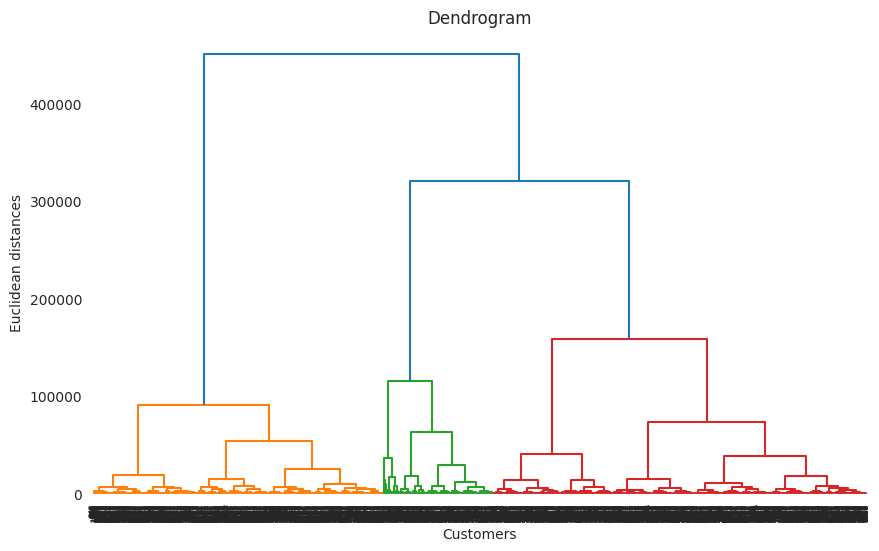

In [106]:
dendoOptimizer(clustering_data)

In [107]:
# Number of clusters = 3
hc, hc_labels = heirarchicalTrainer(3, clustering_data)

In [108]:
customer_profile_1['Cluster'] = hc_labels

In [109]:
customer_profile_1.groupby('Cluster')[['Recency','Frequency','Revenue']].describe()

Recency                                                             \
          count        mean         std  min     25%    50%    75%     max   
Cluster                                                                      
0        2649.0  509.068328  223.980583  0.0  360.00  460.0  634.0  1406.0   
1        2072.0  637.136583  300.560692  0.0  407.75  571.0  819.0  1428.0   
2         785.0  431.899363  179.949763  0.0  335.00  411.0  523.0  1070.0   

        Frequency            ...            Revenue                \
            count      mean  ...  75%   max   count          mean   
Cluster                      ...                                    
0          2649.0  3.817290  ...  5.0  10.0  2649.0  10112.386435   
1          2072.0  2.041023  ...  3.0   6.0  2072.0   3347.252454   
2           785.0  5.701911  ...  7.0  11.0   785.0  19334.956389   

                                                                                
                 std       min          25%        50%          75%        max  
Cluster                                                                         
0        2578.695817   6168.11   7876.44000   9868.755  12175.99500  15453.425  
1        1762.130460      0.00   1916.34625   3500.640   4827.46875   6400.160  
2        3665.855562  15361.71  16588.26000  18240.235  20899.97000  41510.430  

[3 rows x 24 columns]

#### Recency

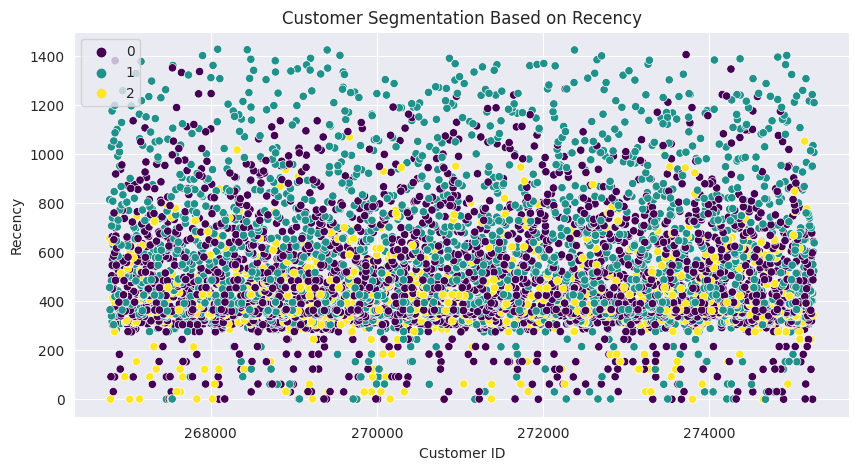

In [110]:
# Plot the segments of customers based on their total purchase amount
plt.figure(figsize=(10,5))
sns.scatterplot(x='Customer ID', y='Recency', hue='Cluster', 
                data=customer_profile_1, palette = 'viridis')
plt.xlabel('Customer ID')
plt.ylabel('Recency')
plt.legend()
plt.title('Customer Segmentation Based on Recency');

#### Frequency

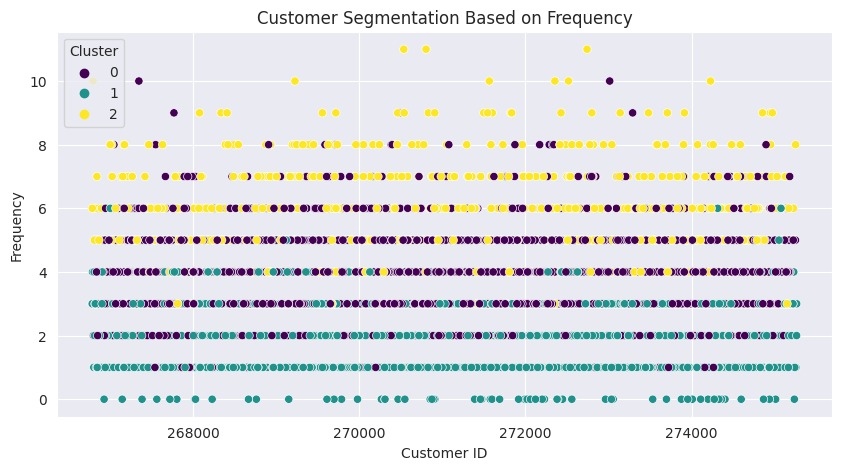

In [111]:
# Plot the segments of customers based on their total purchase amount
plt.figure(figsize=(10,5))
sns.scatterplot(x='Customer ID', y='Frequency', hue='Cluster', 
                data=customer_profile_1, palette = 'viridis')
plt.xlabel('Customer ID')
plt.ylabel('Frequency')
plt.title('Customer Segmentation Based on Frequency');

#### Revenue

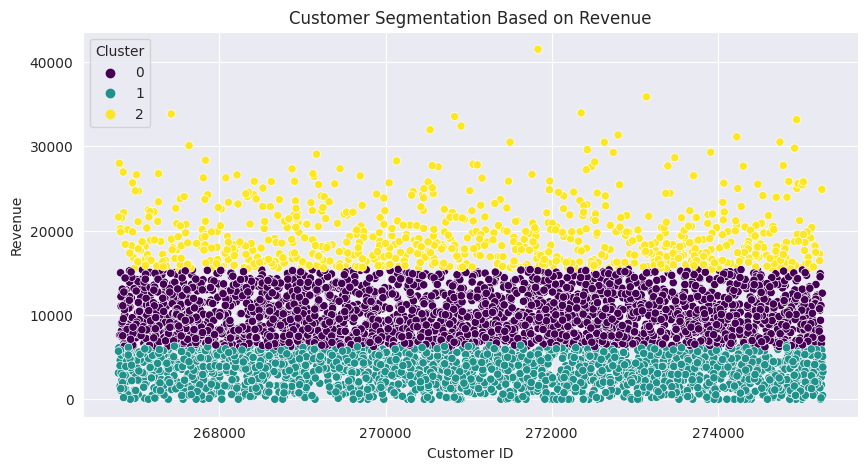

In [112]:
# Plot the segments of customers based on their total purchase amount
plt.figure(figsize=(10,5))
sns.scatterplot(x='Customer ID', y='Revenue', hue='Cluster', 
                data=customer_profile_1, palette = 'viridis')
plt.xlabel('Customer ID')
plt.ylabel('Revenue')
plt.title('Customer Segmentation Based on Revenue');

In [113]:
customer_profile_1.head()

,Customer ID,Recency,RecencyCluster,Revenue,RevenueCluster,Frequency,FrequencyCluster,Overall Score,Segment,Cluster
0,270351,285,1,5769.205,2,3.0,1,4,Mid Value,1
1,270384,285,1,12240.085,1,8.0,2,4,Mid Value,0
2,273420,289,1,583.440,2,1.0,0,3,Mid Value,1
3,271509,289,1,15508.675,0,4.0,1,2,Mid Value,2
4,272357,442,1,9952.735,1,5.0,2,4,Mid Value,0


# Churn Prediction

In order to calculate churn, we will first create a column where we will label the transactions as churn: yes (1) or no (0), based on the fact that, if a customer has been inactive (no purchase made) for the past 2 years (nearly 730 days).

In [114]:
rfm_customer = customer_profile_1.copy()
# Set churn flag based on whether a customer has made a purchase in the past 2 years or not
rfm_customer['Churn'] = np.where(rfm_customer['Recency'] > 730, 1, 0)
rfm_customer.head()

,Customer ID,Recency,RecencyCluster,Revenue,RevenueCluster,Frequency,FrequencyCluster,Overall Score,Segment,Cluster,Churn
0,270351,285,1,5769.205,2,3.0,1,4,Mid Value,1,0
1,270384,285,1,12240.085,1,8.0,2,4,Mid Value,0,0
2,273420,289,1,583.440,2,1.0,0,3,Mid Value,1,0
3,271509,289,1,15508.675,0,4.0,1,2,Mid Value,2,0
4,272357,442,1,9952.735,1,5.0,2,4,Mid Value,0,0


In [115]:
rfm_customer['Churn'].value_counts()

0    4360
1    1146
Name: Churn, dtype: int64

## Undersampling

In [116]:
from sklearn.utils import resample

# Split the dataset by target class
df_class0 = rfm_customer[rfm_customer['Churn'] == 0]
df_class1 = rfm_customer[rfm_customer['Churn'] == 1]

# Undersample the majority class (class 0) to balance the classes
df_class0_downsampled = resample(df_class0, replace=False, n_samples=len(df_class1), random_state=42)

# Combine the undersampled majority class and the minority class into a new balanced dataset
df_downsampled = pd.concat([df_class0_downsampled, df_class1])

# Shuffle the rows of the balanced dataset
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_downsampled['Churn'].value_counts()

1    1146
0    1146
Name: Churn, dtype: int64

In [117]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop(['Customer ID', 'RecencyCluster', 'RevenueCluster', 'FrequencyCluster', 'Overall Score', 'Segment', 'Cluster', 'Churn'], axis=1), 
                                                    df_downsampled['Churn'], 
                                                    test_size=0.3, 
                                                    stratify=df_downsampled['Churn'],
                                                    random_state=42)

In [118]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def run_churnClassification(model, X_train, X_test, y_train, y_test):

    # Perform stratified 10 fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro')

    # Printing the average f1-score
    print(f"Average F1-Score: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate model performance
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4f}".format(accuracy))

    precision = precision_score(y_test, y_pred)
    print("Precision: {:.4f}".format(precision))

    recall = recall_score(y_test, y_pred)
    print("Recall: {:.4f}".format(recall))

    f1 = f1_score(y_test, y_pred)
    print("F1 Score: {:.4f}".format(f1))

    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient: {:.4f}".format(mcc))

    print('\nClassification Report:\n', classification_report(y_test, y_pred))


### Logistic Regression

In [119]:
log_model = LogisticRegression()
run_churnClassification(log_model, X_train, X_test, y_train, y_test)

Average F1-Score: 0.986 (+/- 0.041)
Confusion Matrix:
 [[343   1]
 [  0 344]]
Accuracy: 0.9985
Precision: 0.9971
Recall: 1.0000
F1 Score: 0.9985
Matthews Correlation Coefficient: 0.9971

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       344

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



### Random Forest Classifier

In [120]:
rfc_model = RandomForestClassifier()
run_churnClassification(rfc_model, X_train, X_test, y_train, y_test)

Average F1-Score: 0.999 (+/- 0.002)
Confusion Matrix:
 [[343   1]
 [  0 344]]
Accuracy: 0.9985
Precision: 0.9971
Recall: 1.0000
F1 Score: 0.9985
Matthews Correlation Coefficient: 0.9971

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       344

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



### XGBoost Classifier

In [121]:
xgbc_model = XGBClassifier()
run_churnClassification(xgbc_model, X_train, X_test, y_train, y_test)

Average F1-Score: 0.999 (+/- 0.002)
Confusion Matrix:
 [[344   0]
 [  0 344]]
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       344

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



## Oversampling

In [122]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rfm_customer.drop(['Customer ID', 'RecencyCluster', 'RevenueCluster', 'FrequencyCluster', 'Overall Score', 'Segment', 'Cluster', 'Churn'], axis=1), 
                                                    rfm_customer['Churn'], 
                                                    test_size=0.3, random_state=42)

# Initializing SMOTE
smote = SMOTE(random_state=42)

# Resampling the training data using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Printing the count of each class in the original and resampled data
print("Class distribution before resampling:\n", y_train.value_counts())
print("\nClass distribution after resampling:\n", y_train_smote.value_counts())

Class distribution before resampling:
 0    3054
1     800
Name: Churn, dtype: int64

Class distribution after resampling:
 0    3054
1    3054
Name: Churn, dtype: int64


### Logistic Regression

In [123]:
# Running the logistic regression model with SMOTE
log_model = LogisticRegression()
run_churnClassification(log_model, X_train_smote, X_test, y_train_smote, y_test)

Average F1-Score: 1.000 (+/- 0.001)
Confusion Matrix:
 [[1305    1]
 [   0  346]]
Accuracy: 0.9994
Precision: 0.9971
Recall: 1.0000
F1 Score: 0.9986
Matthews Correlation Coefficient: 0.9982

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1306
           1       1.00      1.00      1.00       346

    accuracy                           1.00      1652
   macro avg       1.00      1.00      1.00      1652
weighted avg       1.00      1.00      1.00      1652



### Random Forest Classifier

In [124]:
rfc_model = RandomForestClassifier()
run_churnClassification(rfc_model, X_train_smote, X_test, y_train_smote, y_test)

Average F1-Score: 1.000 (+/- 0.000)
Confusion Matrix:
 [[1305    1]
 [   0  346]]
Accuracy: 0.9994
Precision: 0.9971
Recall: 1.0000
F1 Score: 0.9986
Matthews Correlation Coefficient: 0.9982

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1306
           1       1.00      1.00      1.00       346

    accuracy                           1.00      1652
   macro avg       1.00      1.00      1.00      1652
weighted avg       1.00      1.00      1.00      1652



### XGBoost

In [125]:
# Fitting the model on the training data
xgbc_model = XGBClassifier()
run_churnClassification(xgbc_model, X_train_smote, X_test, y_train_smote, y_test)

Average F1-Score: 1.000 (+/- 0.000)
Confusion Matrix:
 [[1306    0]
 [   0  346]]
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1306
           1       1.00      1.00      1.00       346

    accuracy                           1.00      1652
   macro avg       1.00      1.00      1.00      1652
weighted avg       1.00      1.00      1.00      1652



# Customer Lifetime Value (CLV) Prediction

In [126]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rfm_customer.drop(['Customer ID', 'RecencyCluster', 'RevenueCluster', 'FrequencyCluster', 'Overall Score', 'Segment', 'Cluster', 'Churn', 'Revenue'], axis=1), 
                                                    rfm_customer['Revenue'], 
                                                    test_size=0.3, 
                                                    random_state=42)

In [127]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

def run_CLVRegression(model, X_train, X_test, y_train, y_test):
    
    # Train regression model
    model.fit(X_train, y_train)

    print('10-fold Cross Validation')
    # Perform 10 fold cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10)

    # Print the mean score and standard deviation
    print("Mean CV Score: {:.4f}".format(np.mean(scores)))
    print("Std Deviation CV Score: {:.4f}".format(np.std(scores)))

    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    print('\nPrediction Evaluation')

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: {:.4f}".format(rmse))
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error: {:.4f}".format(mae))
    medae = median_absolute_error(y_test, y_pred)
    print("Median Absolute Error: {:.4f}".format(medae))
    r2_score = model.score(X_test, y_test)
    print("R-squared score: {:.4f}".format(r2_score))
    adj_r2_score = 1 - (1-r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print("Adjusted R-squared score: {:.4f}".format(adj_r2_score))
    spearman_corr, _ = stats.spearmanr(y_test, y_pred)
    print("Spearman correlation: {:.4f}".format(spearman_corr))

    return [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

## Linear Models

In [128]:
eval_results = {}

In [129]:
reg_model = LinearRegression()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(reg_model, X_train, X_test, y_train, y_test)
eval_results['Linear Regression'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6045
Std Deviation CV Score: 0.0322

Prediction Evaluation
Root Mean Squared Error: 3523.9500
Mean Absolute Error: 2757.4986
Median Absolute Error: 2234.8808
R-squared score: 0.6261
Adjusted R-squared score: 0.6256
Spearman correlation: 0.7732


In [130]:
lasso_model = Lasso(alpha=1.0)
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(lasso_model, X_train, X_test, y_train, y_test)
eval_results['Lasso Regression'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6045
Std Deviation CV Score: 0.0322

Prediction Evaluation
Root Mean Squared Error: 3523.9531
Mean Absolute Error: 2757.5279
Median Absolute Error: 2234.9656
R-squared score: 0.6261
Adjusted R-squared score: 0.6256
Spearman correlation: 0.7732


In [131]:
lars_model = Lars()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(lars_model, X_train, X_test, y_train, y_test)
eval_results['LARS'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6045
Std Deviation CV Score: 0.0322

Prediction Evaluation
Root Mean Squared Error: 3523.9500
Mean Absolute Error: 2757.4986
Median Absolute Error: 2234.8808
R-squared score: 0.6261
Adjusted R-squared score: 0.6256
Spearman correlation: 0.7732


In [132]:
laslar_model = LassoLars()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(laslar_model, X_train, X_test, y_train, y_test)
eval_results['Lasso LARS'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6045
Std Deviation CV Score: 0.0322

Prediction Evaluation
Root Mean Squared Error: 3523.9531
Mean Absolute Error: 2757.5280
Median Absolute Error: 2234.9691
R-squared score: 0.6261
Adjusted R-squared score: 0.6256
Spearman correlation: 0.7732


In [133]:
ridge_model = Ridge(alpha=1.0)
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(ridge_model, X_train, X_test, y_train, y_test)
eval_results['Ridge Regression'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6045
Std Deviation CV Score: 0.0322

Prediction Evaluation
Root Mean Squared Error: 3523.9521
Mean Absolute Error: 2757.5184
Median Absolute Error: 2234.9375
R-squared score: 0.6261
Adjusted R-squared score: 0.6256
Spearman correlation: 0.7732


In [134]:
ridgecv_model = RidgeCV(alphas=(0.1, 1.0, 10.0))
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(ridgecv_model, X_train, X_test, y_train, y_test)
eval_results['Ridge CV'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6045
Std Deviation CV Score: 0.0322

Prediction Evaluation
Root Mean Squared Error: 3523.9521
Mean Absolute Error: 2757.5184
Median Absolute Error: 2234.9380
R-squared score: 0.6261
Adjusted R-squared score: 0.6256
Spearman correlation: 0.7732


In [135]:
sgd_model = SGDRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(sgd_model, X_train, X_test, y_train, y_test)
eval_results['SGD Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: -500715343212851494912.0000
Std Deviation CV Score: 587289832876583813120.0000

Prediction Evaluation
Root Mean Squared Error: 33146737513134.8047
Mean Absolute Error: 29697505273824.8125
Median Absolute Error: 25936237448302.9531
R-squared score: -33083780436582957056.0000
Adjusted R-squared score: -33123906307336847360.0000
Spearman correlation: -0.3096


In [136]:
psr_model = PoissonRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(psr_model, X_train, X_test, y_train, y_test)
eval_results['Poisson Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.5420
Std Deviation CV Score: 0.0313

Prediction Evaluation
Root Mean Squared Error: 3874.0635
Mean Absolute Error: 2965.8719
Median Absolute Error: 2523.3994
R-squared score: 0.5593
Adjusted R-squared score: 0.5588
Spearman correlation: 0.7732


In [137]:
huber_model = HuberRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(huber_model, X_train, X_test, y_train, y_test)
eval_results['Huber Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.6024
Std Deviation CV Score: 0.0339

Prediction Evaluation
Root Mean Squared Error: 3530.3380
Mean Absolute Error: 2740.2240
Median Absolute Error: 2235.7131
R-squared score: 0.6247
Adjusted R-squared score: 0.6243
Spearman correlation: 0.7753


## Nearest Neighbors

In [138]:
knn_model = KNeighborsRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(knn_model, X_train, X_test, y_train, y_test)
eval_results['KNN Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.4448
Std Deviation CV Score: 0.0365

Prediction Evaluation
Root Mean Squared Error: 4159.5369
Mean Absolute Error: 3259.1572
Median Absolute Error: 2770.3455
R-squared score: 0.4790
Adjusted R-squared score: 0.4784
Spearman correlation: 0.6911


## Ensemble Trees

In [139]:
rfr_model = RandomForestRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(rfr_model, X_train, X_test, y_train, y_test)
eval_results['Random Forest Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.4564
Std Deviation CV Score: 0.0504

Prediction Evaluation
Root Mean Squared Error: 4197.7257
Mean Absolute Error: 3270.2853
Median Absolute Error: 2694.7019
R-squared score: 0.4694
Adjusted R-squared score: 0.4688
Spearman correlation: 0.7103


## Gradient Boosting

In [140]:
lgbm_model = LGBMRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(lgbm_model, X_train, X_test, y_train, y_test)
eval_results['LGBM Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.5775
Std Deviation CV Score: 0.0283

Prediction Evaluation
Root Mean Squared Error: 3628.4738
Mean Absolute Error: 2828.6001
Median Absolute Error: 2306.8388
R-squared score: 0.6036
Adjusted R-squared score: 0.6031
Spearman correlation: 0.7771


In [141]:
gbr_model = GradientBoostingRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(gbr_model, X_train, X_test, y_train, y_test)
eval_results['Gradient Boost'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.5986
Std Deviation CV Score: 0.0336

Prediction Evaluation
Root Mean Squared Error: 3574.9933
Mean Absolute Error: 2792.1256
Median Absolute Error: 2258.8616
R-squared score: 0.6152
Adjusted R-squared score: 0.6147
Spearman correlation: 0.7782


In [142]:
xgbr_model = XGBRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(xgbr_model, X_train, X_test, y_train, y_test)
eval_results['XGBoost'] = mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr

10-fold Cross Validation
Mean CV Score: 0.5373
Std Deviation CV Score: 0.0453

Prediction Evaluation
Root Mean Squared Error: 3856.5185
Mean Absolute Error: 2983.6006
Median Absolute Error: 2401.5972
R-squared score: 0.5522
Adjusted R-squared score: 0.5516
Spearman correlation: 0.7565


In [143]:
ada_model = AdaBoostRegressor()
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(ada_model, X_train, X_test, y_train, y_test)
eval_results['Adaboost'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.5467
Std Deviation CV Score: 0.0320

Prediction Evaluation
Root Mean Squared Error: 3831.6652
Mean Absolute Error: 3072.0564
Median Absolute Error: 2586.9745
R-squared score: 0.5579
Adjusted R-squared score: 0.5574
Spearman correlation: 0.7814


## Advanced Transformer

In [144]:
base_estimator = LGBMRegressor()
ttr_model = TransformedTargetRegressor(regressor=base_estimator, transformer=QuantileTransformer(output_distribution='normal'))
mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr = run_CLVRegression(ttr_model, X_train, X_test, y_train, y_test)
eval_results['Transformed Regressor'] = [mse, rmse, mae, medae, r2_score, adj_r2_score, spearman_corr]

10-fold Cross Validation
Mean CV Score: 0.5774
Std Deviation CV Score: 0.0320

Prediction Evaluation
Root Mean Squared Error: 3625.9630
Mean Absolute Error: 2794.0662
Median Absolute Error: 2224.6624
R-squared score: 0.6041
Adjusted R-squared score: 0.6036
Spearman correlation: 0.7773


In [145]:
results = pd.DataFrame(eval_results, index=['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score', 'Adjusted R2 score', 'Spearman R']).transpose()
results = results.sort_values(by=['Adjusted R2 score', 'Median Absolute Error', 'Root Mean Squared Error', 'Spearman R'], ascending=False)
results

,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score,Adjusted R2 score,Spearman R
Linear Regression,1.241822e+07,3.523950e+03,2.757499e+03,2.234881e+03,6.260677e-01,6.256141e-01,0.773154
LARS,1.241822e+07,3.523950e+03,2.757499e+03,2.234881e+03,6.260677e-01,6.256141e-01,0.773154
Ridge Regression,1.241824e+07,3.523952e+03,2.757518e+03,2.234938e+03,6.260672e-01,6.256137e-01,0.773154
Ridge CV,1.241824e+07,3.523952e+03,2.757518e+03,2.234938e+03,6.260672e-01,6.256137e-01,0.773154
Lasso Regression,1.241825e+07,3.523953e+03,2.757528e+03,2.234966e+03,6.260670e-01,6.256135e-01,0.773154
Lasso LARS,1.241825e+07,3.523953e+03,2.757528e+03,2.234969e+03,6.260670e-01,6.256135e-01,0.773154
Huber Regressor,1.246329e+07,3.530338e+03,2.740224e+03,2.235713e+03,6.247107e-01,6.242556e-01,0.775285
Gradient Boost,1.278058e+07,3.574993e+03,2.792126e+03,2.258862e+03,6.151566e-01,6.146899e-01,0.778191
Transformed Regressor,1.314761e+07,3.625963e+03,2.794066e+03,2.224662e+03,6.041048e-01,6.036246e-01,0.777276
LGBM Regressor,1.316582e+07,3.628474e+03,2.828600e+03,2.306839e+03,6.035563e-01,6.030755e-01,0.777085


## Create Future Data For Prediction

In [146]:
# Predict CLV
future_date = pd.to_datetime(max(X_train['Recency']), unit='D') + timedelta(days=365)
future_rfm = pd.DataFrame({
    'Recency': [(future_date - pd.to_datetime(x, unit='D')).days for x in X_train['Recency']],
    'Frequency': X_train['Frequency'],
})
future_rfm.head()

,Recency,Frequency
2303,1351,6.0
4024,1306,4.0
5269,553,1.0
2245,1356,5.0
5286,657,1.0


In [147]:
future_cltv = reg_model.predict(future_rfm)
future_rfm['CLTV'] = future_cltv
future_rfm = future_rfm.sort_values('CLTV', ascending=False)  #.reset_index(drop=True)

In [148]:
future_rfm.head(10)

,Recency,Frequency,CLTV
1838,1388,11.0,28571.428683
1386,1424,11.0,28570.149207
593,1474,11.0,28568.372157
1691,1306,10.0,25976.351293
2186,1361,10.0,25974.396538
2836,1400,10.0,25973.010439
556,1476,10.0,25970.309323
3284,1243,9.0,23380.598624
1944,1381,9.0,23375.693966
1883,1385,9.0,23375.551802
